In [2]:
#generators
train_ds=keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size=(256,256)
)
validation_ds=keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/test',
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [16]:
# Extract images and labels from the validation dataset
X_test = []
y_test = []

for images, labels in validation_ds:
    X_test.append(images)
    y_test.append(labels)

# Convert lists to tensors
X_test = tf.concat(X_test, axis=0)
y_test = tf.concat(y_test, axis=0)


In [3]:
#Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [22]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,351,041 (12.78 MB)

 Trainable params: 3,350,465 (12.78 MB)

 Non-trainable params: 576 (2.25 KB)

In [23]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [24]:
history = model.fit(train_ds,epochs=100,validation_data=validation_ds)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.6040 - loss: 0.8840 - val_accuracy: 0.5414 - val_loss: 0.7113
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.7391 - loss: 0.5276 - val_accuracy: 0.7536 - val_loss: 0.5086
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8087 - loss: 0.4212 - val_accuracy: 0.8092 - val_loss: 0.4245
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8554 - loss: 0.3355 - val_accuracy: 0.8360 - val_loss: 0.3758
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8989 - loss: 0.2436 - val_accuracy: 0.8832 - val_loss: 0.2908
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9325 - loss: 0.1776 - val_accuracy: 0.8808 - val_loss: 0.3061
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9489 - loss: 0.1238 - val_accuracy: 0.7946 - val_loss: 0.9493
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9641 - loss: 0

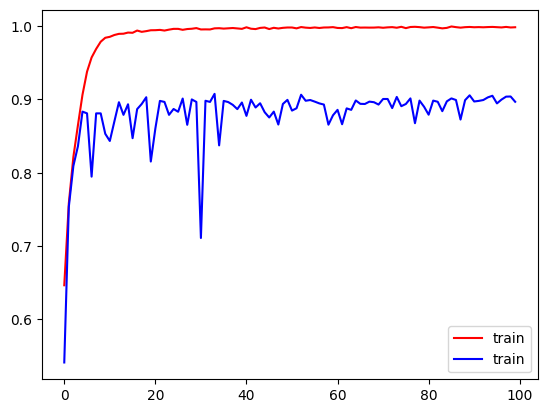

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='train')
plt.legend()
plt.show()

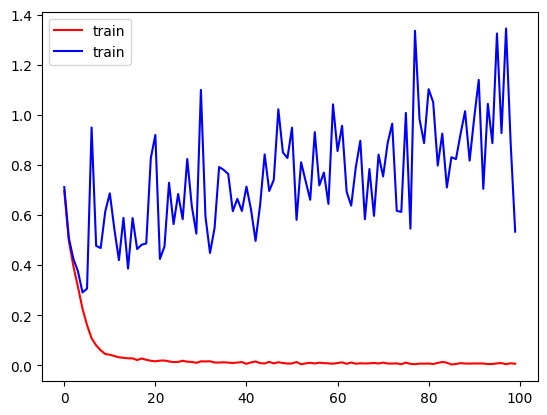

In [26]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='train')
plt.legend()
plt.show()

In [27]:
model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9008 - loss: 0.4783


[0.5334576368331909, 0.8966000080108643]

In [36]:
import cv2

test_img = cv2.imread('/kaggle/input/mydataset/dog.jpg')

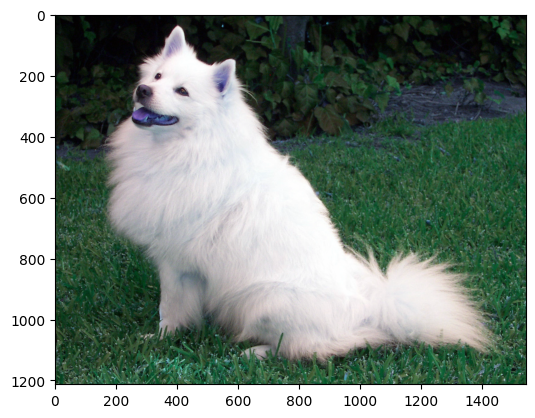

In [37]:
plt.imshow(test_img)

In [38]:
test_img.shape

(1213, 1546, 3)

In [39]:
test_img = cv2.resize(test_img,(256,256))

In [40]:
test_input = test_img.reshape(1,256,256,3)

In [41]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[1.]], dtype=float32)